In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
df = pd.read_csv('T20 Jan11-Feb11.csv')

In [3]:
df.replace("-", np.nan, inplace=True)
df.dropna(inplace=True)

In [4]:
numerical_columns = ['Matches', 'Innings', 'Runs', 'Not Outs', 'Strike Rate', 'Average']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)


In [5]:
df["Runs_Per_Match"] = df["Runs"] / df["Matches"]
df["Not_Out_Ratio"] = df["Not Outs"] / df["Innings"]
df["Consistency"] = df["Average"] / df["Strike Rate"]

In [6]:
features = ['Matches', 'Innings', 'Runs', 'Not Outs', 'Strike Rate', 'Runs_Per_Match', 'Not_Out_Ratio', 'Consistency']
target = 'Average'

X = df[features]
y = df[target]

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

In [9]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 2936, number of used features: 8
[LightGBM] [Info] Start training from score 13.753815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMRegressor(max_depth=6, n_estimators=200, random_state=42)

In [11]:
y_pred_rf = best_rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

In [12]:
def evaluate_model(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print("-" * 40)

evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("LightGBM", y_test, y_pred_lgb)

Random Forest Performance:
Mean Absolute Error (MAE): 0.30
Root Mean Squared Error (RMSE): 2.03
R² Score: 0.97
----------------------------------------
XGBoost Performance:
Mean Absolute Error (MAE): 0.33
Root Mean Squared Error (RMSE): 2.08
R² Score: 0.96
----------------------------------------
LightGBM Performance:
Mean Absolute Error (MAE): 0.43
Root Mean Squared Error (RMSE): 2.19
R² Score: 0.96
----------------------------------------


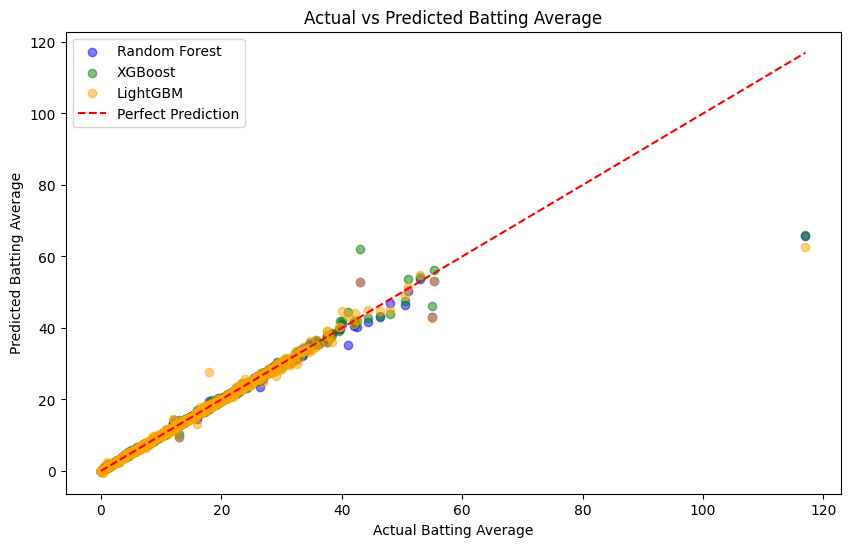

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.5, label='XGBoost')
plt.scatter(y_test, y_pred_lgb, color='orange', alpha=0.5, label='LightGBM')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Batting Average")
plt.ylabel("Predicted Batting Average")
plt.title("Actual vs Predicted Batting Average")
plt.legend()
plt.show()

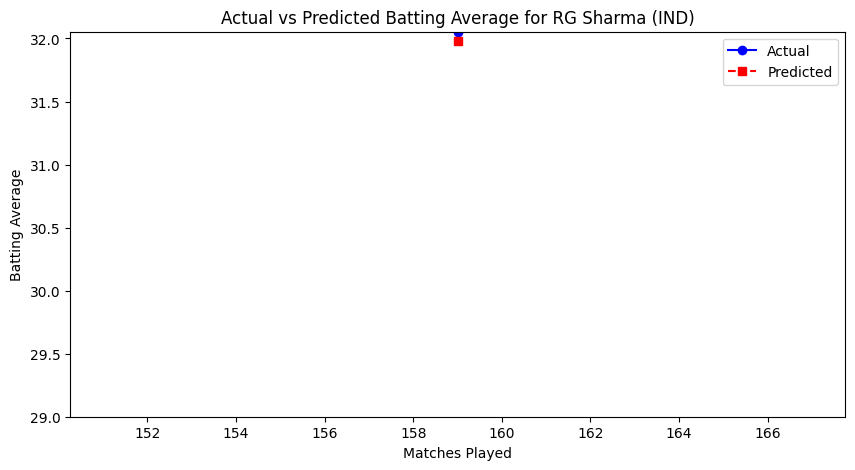

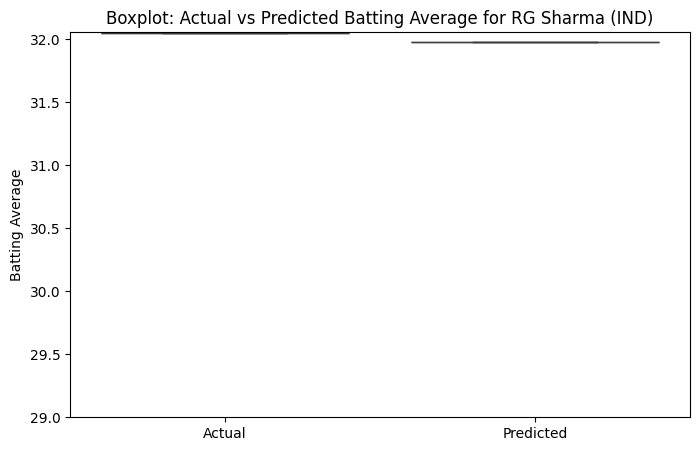

C:\Users\HP\AppData\Local\Temp\ipykernel_13784\1881411429.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(stats.keys()), y=list(stats.values()), palette="viridis")


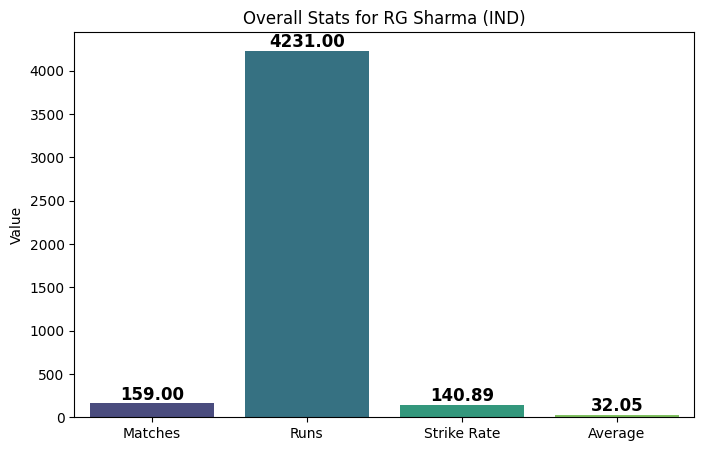

In [20]:
def analyze_player(player_name):
    player_data = df[df["Name"] == player_name].copy()

    if player_data.empty:
        print(f"No data found for player: {player_name}")
        return

    player_data = player_data.sort_values(by="Matches")

    if not all(f in player_data.columns for f in features):
        print("Feature mismatch error. Check dataset column names.")
        return

    try:
        player_data["Predicted_Avg"] = best_rf_model.predict(player_data[features])
    except Exception as e:
        print("Error in prediction:", str(e))
        return

    # Line Plot: Actual vs Predicted Batting Average Over Matches
    plt.figure(figsize=(10, 5))
    plt.plot(player_data["Matches"], player_data["Average"], marker="o", linestyle="-", label="Actual", color="blue")
    plt.plot(player_data["Matches"], player_data["Predicted_Avg"], marker="s", linestyle="--", label="Predicted", color="red")
    plt.xlabel("Matches Played")
    plt.ylabel("Batting Average")
    plt.title(f"Actual vs Predicted Batting Average for {player_name}")
    plt.ylim(29)
    plt.legend()
    plt.show()

    # Boxplot: Distribution of Actual vs Predicted Averages
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=player_data[["Average", "Predicted_Avg"]])
    plt.ylabel("Batting Average")
    plt.title(f"Boxplot: Actual vs Predicted Batting Average for {player_name}")
    plt.ylim(29)
    plt.xticks(ticks=[0, 1], labels=["Actual", "Predicted"])
    plt.show()

    # Bar Chart: Overall Stats Representation
    stats = {
        "Matches": player_data["Matches"].sum(),
        "Runs": player_data["Runs"].sum(),
        "Strike Rate": player_data["Strike Rate"].mean(),
        "Average": player_data["Average"].mean(),
    }

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=list(stats.keys()), y=list(stats.values()), palette="viridis")

    # Add value labels on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    plt.ylabel("Value")
    plt.title(f"Overall Stats for {player_name}")
    plt.show()
# Example usage:
analyze_player("RG Sharma (IND)")
